In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
 
df = pd.read_json('../data/database-27-10.json')

target = "Covid-19-Pandemie"
short = "covid"

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [36]:
df = df.loc[(df['date'] >= "2022-07-16") & (df['date'] <= "2022-10-27")]

#### Füge ein neues Feature hinzu: Themengebiet

In [37]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [38]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Filter die Artikel nach: Sind dem Themengebiet „Covid-19-Pandemie“ zugeordnet

In [39]:
df = df.loc[(df.topic == target)]

## 1. Gruppiere Artikel nach: Monat (eindeutig)

In [40]:
df_month = df.groupby(["month", "year"]).size().reset_index(name="amount")

In [41]:
df_month['date'] = df_month['month'].astype(str) + " " + df_month['year'].astype(str)

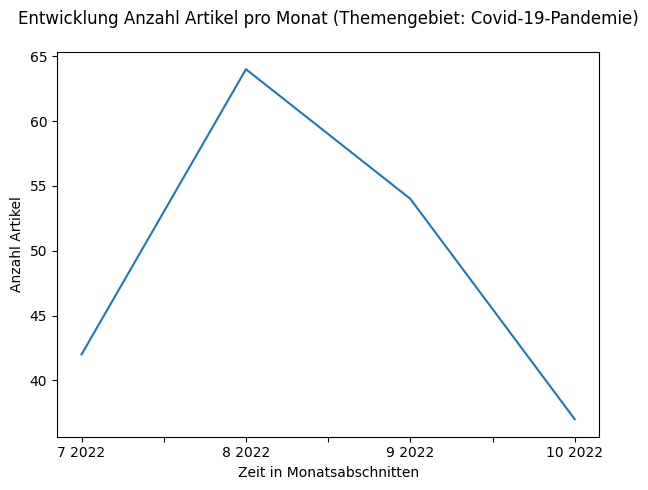

In [42]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_month.plot(kind="line", x="date", y="amount", ax=ax, xlabel="Zeit in Monatsabschnitten", figsize=(7,5), ylabel="Anzahl Artikel", legend=False)

ax.set_title(f'Entwicklung Anzahl Artikel pro Monat (Themengebiet: {target})', pad=20)

fig.savefig(f'figures/bar-{short}-trend-month.png')

## 2. Gruppiere Artikel nach: Woche (eindeutig)

In [43]:
df_year = df.groupby(["week", "year"]).size().reset_index(name="amount")

#### Füge ein neues Feature hinzu: Datum (formatiert)

In [44]:
df_year['date'] = "KW " + df_year['week'].astype(str) + " " + df_year['year'].astype(str)

#### Füge ein neues Feature hinzu: Sekunden

In [45]:
def week_year_to_date(row):
    date = "{}-{}-1".format(row["year"], row["week"])
    return dt.strptime(date, "%Y-%W-%w").timestamp()

df_year['seconds'] = df_year.apply(week_year_to_date, axis=1)

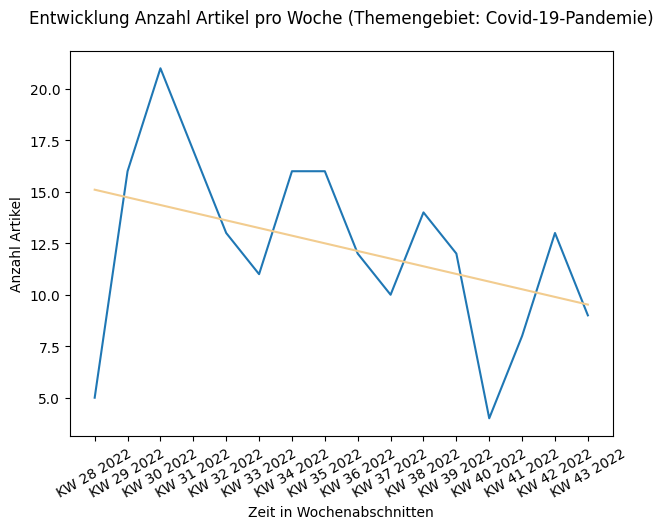

In [46]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_year.plot(kind="line", x="seconds", y="amount", ax=ax, rot=30, xlabel="Zeit in Wochenabschnitten", figsize=(7,5), ylabel="Anzahl Artikel", legend=False)
ax.set_xticks(df_year.seconds.to_list())
ax.set_xticklabels(df_year.date)

z = np.polyfit(df_year.seconds, df_year.amount, 1)
p = np.poly1d(z)
ax.plot(df_year.seconds, p(df_year.seconds), color="#f2cc8f")

ax.set_title(f'Entwicklung Anzahl Artikel pro Woche (Themengebiet: {target})', pad=20)

fig.savefig(f'figures/bar-{short}-trend-week.png')